# 🤖 Predictive Modeling for Defect Detection in Custom Bicycle Production

This notebook builds a decision tree classifier to identify high-risk product configurations that lead to defects during GEAR's bicycle assembly process. It incorporates cost-benefit modeling to evaluate the economic impact of different quality control strategies.


## 🎯 Problem Definition

GEAR is experiencing a rise in customer complaints due to defective bicycles. The goal is to identify patterns in product customization options that are more prone to defects, enabling more targeted quality inspections.

- **Target variable**: `Defect` (Yes/No)
- **Features**: All customization options (e.g., Frame, Drivetrain, Suspension, Brakes)
- **Excluded**: `Return`, `Warranty` – due to target leakage

In [1]:
import pandas as pd

import numpy as np 

# Decision tree: prepare data + estimation
from sklearn.preprocessing import LabelEncoder #to encode categorial variables
from sklearn.model_selection import train_test_split # split data in training and testing sample
from sklearn.tree import DecisionTreeClassifier # decision trees


# Visualization of the decision tree
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree

# evaluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.preprocessing import MinMaxScaler

# cross-validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv(r'../data/predictive-modeling-data.csv')

## 🧪 Modeling & Evaluation Process

- Categorical variables were encoded numerically
- Dataset split into training and test sets
- A range of tree depths and splits were tested using cross-validation
- The optimal model was selected based on:
  - High predictive power (accuracy)
  - Low variance in test scores
  - Maximized economic value (profit)

In [3]:
cols_to_encode = df.select_dtypes(include='object').drop(columns=['Return', 'Warranty']).columns

for col in cols_to_encode:
    le = LabelEncoder()
    df[f"{col}_encoded"] = le.fit_transform(df[col])

encoded_feature_cols = [col for col in df.columns if col.endswith('_encoded') and col != 'Defect_encoded']

X = df[encoded_feature_cols + ['WheelSize']]
y = df['Defect_encoded']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
pm = [[10000, 7500],
       [4000, 7100]]

def ex_payoff(y_true, y_pred):
    cmatrix =  confusion_matrix(y_true, y_pred, labels=[0,1]) 
    payoff = np.sum(np.multiply(cmatrix,pm))/len(y_pred)
    return payoff

my_score = make_scorer(ex_payoff) 

In [5]:
parameters = {
    'max_depth': range(1, 10),
    'class_weight': [
        {0:1, 1:1}, {0:2, 1:1}, {0:3, 1:1},
        {0:1, 1:2}, {0:1, 1:3}
    ],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.05, 0.1]
}

grid_search_cv = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, verbose=1, cv=10, scoring = my_score)

grid_search_cv.fit(X, y)

Fitting 10 folds for each of 225 candidates, totalling 2250 fits


,estimator,DecisionTreeC...andom_state=1)
,param_grid,"{'ccp_alpha': [0.0, 0.001, ...], 'class_weight': [{0: 1, 1: 1}, {0: 2, 1: 1}, ...], 'max_depth': range(1, 10)}"
,scoring,make_scorer(e...hod='predict')
,n_jobs,None
,refit,True
,cv,10
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [6]:
grid_search_cv.best_estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,7
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,1
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,"{0: 1, 1: 1}"


## 🔍 Feature Importance

Top defect predictors included:
- Frame Material (e.g., Titanium vs. Carbon)
- Brake System (Hydraulic vs. Mechanical)
- Gear System type

In [7]:
clf_final = DecisionTreeClassifier(ccp_alpha=0.001, class_weight={0: 1, 1: 1}, max_depth=7, random_state=1)
clf_final = clf_final.fit(X, y)

feature_importance = pd.DataFrame(clf_final.feature_importances_, index = X.columns)
feature_importance.sort_values(by=0, ascending=False)

,0
Drivetrain_encoded,0.552978
WheelType_encoded,0.170211
Frame_encoded,0.124231
Pedals_encoded,0.105556
WheelSize,0.037232
Seat_encoded,0.009792
Suspension_encoded,0.000000
Tires_encoded,0.000000
Brake_encoded,0.000000
Gear_encoded,0.000000


## 🌲 Tree Visualization

Due to depth > 8, a pruned tree (depth=7) was visualized to preserve interpretability.

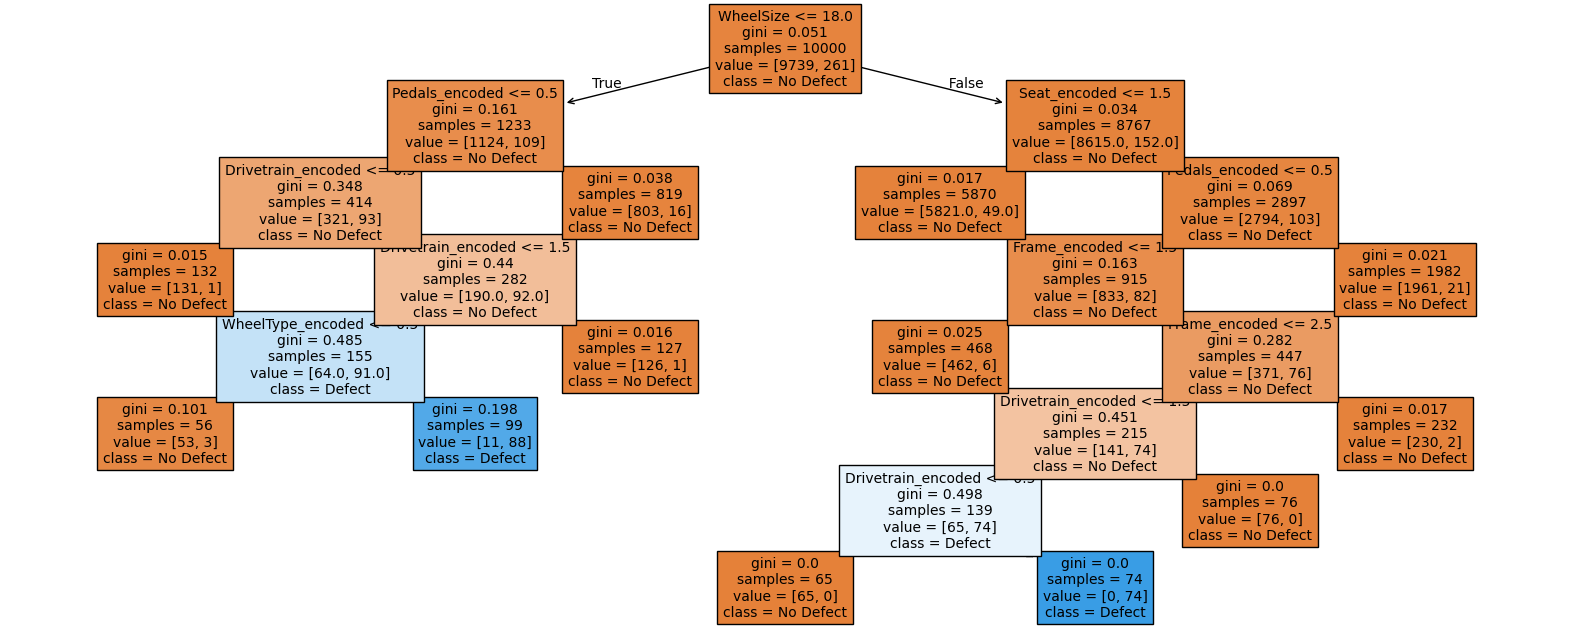

In [8]:
fig = plt.figure(figsize=(20,8))
_ = plot_tree(clf_final,
                  feature_names=X.columns.to_list(),
                  class_names=['No Defect', 'Defect'],
                  filled=True,
                  fontsize=10)

## 💰 Economic Cost Modeling

Each inspection costs **\$500**.  
A defect **not intercepted** reduces a customer’s lifetime value by **\$6,000**, plus approximately **\$2,000** in warranty/return costs.  
If caught, repair costs **\$400**.

We simulated:

- **Random inspection** of 1,000 bicycles  
- **Model-guided inspection** based on predicted defect risk


In [9]:
pm_random_inspection = [
    [9500, 9500],  
    [9100, 9100] 
]

def calculate_profit(y_true, y_pred, profit_matrix):
    cmatrix = confusion_matrix(y_true, y_pred, labels=[0, 1])
    payoff = np.sum(np.multiply(cmatrix, profit_matrix)) / len(y_pred)
    return payoff

random_inspection_profits = []
decision_tree_profits = []

for i in range(10):
    sampled_df = df.sample(n=1000, random_state=i)

    X_sample = sampled_df[encoded_feature_cols + ['WheelSize']]
    y_sample = sampled_df['Defect_encoded']
    
    random_inspection_profit = calculate_profit(y_sample, y_sample, pm_random_inspection)
    random_inspection_profits.append(random_inspection_profit)

    y_pred = clf_final.predict(X_sample)
    decision_tree_profit = ex_payoff(y_sample, y_pred)
    decision_tree_profits.append(decision_tree_profit)

mean_random_inspection_profit = np.mean(random_inspection_profits)
mean_decision_tree_profit = np.mean(decision_tree_profits)


### Outcome:
The decision tree model significantly outperformed random inspection in terms of retained profit, while also reducing inspection burden.

In [10]:

print(f"Average expected profit from random inspection: {mean_random_inspection_profit:.2f}")
print(f"Average expected profit from decision tree: {mean_decision_tree_profit:.2f}")

Average expected profit from random inspection: 9489.88
Average expected profit from decision tree: 9892.33










## 🧠 Recommendation

GEAR should adopt model-based inspection over random sampling. It leads to higher profitability, reduces customer churn, and enables more precise targeting of high-risk configurations.
